## Imports

In [1]:
import os
import cv2
import numpy as np
import shutil
import threading
import urllib
from PIL import Image, ImageFile
from datetime import datetime
import ipywidgets.widgets as widgets
from IPython.display import display
from matplotlib import pyplot as plt

## Set Jetbot IP and port

In [7]:
jetbot_ip = 'localhost'
jetbot_port = 8080

## Create dataset directory if it doesn't exist

In [3]:
dataset_dir = 'dataset'
try:
    os.makedirs(dataset_dir)
except FileExistsError:
    print('Dataset directory not created becasue it already exists')

Dataset directory not created becasue it already exists


## Gamepad Check
This step is similar to the "Teleoperation" task of Jetbot's "Getting Started" series (https://jetbot.org/master/examples/teleoperation.html).
In this task, we will a gamepad to collect training data.

The first thing we want to do is create an instance of the Controller widget, which we'll use to control Jetbot's left and right motor.
The Controller widget takes a index parameter, which specifies the number of the controller.
This is useful in case you have multiple controllers attached, or some gamepads appear as multiple controllers.
To determine the index of the controller you're using, visit http://html5gamepad.com.
Press buttons on the gamepad you're using.
Remember the index of the gamepad that is responding to the button presses.
Next, we'll create and display our controller using that index.

In [4]:
controller = widgets.Controller(index=0)
display(controller)

Controller()

In my case I'm using a PlayStation 4 controller with the index 0.

I'm using the right trigger (button 7, "R2") to control the left motor and the left trigger (button 6, "l2") to control the right motor.
The reason behind this is that applying more power to the left motor turns the jetbot right and the other way around.
The "X" button (button 0) will be used to stop the recording procedure.

In [5]:
left_motor_button = 7
right_motor_button = 6
stop_button = 0

## Reminder to start the REST-Service on your Jetbot

## Camera Check
Run the cell below to check the camera angle, repeat until you have the desired angle.

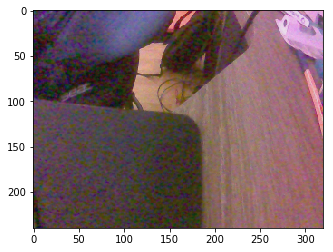

In [8]:
req = urllib.request.urlopen('http://{0}:{1}/camera'.format(jetbot_ip,jetbot_port))
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
fig, ax1 = plt.subplots()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=0, vmax=255)

## Motor Check
Pick up the JetBot and run the cell below to start the motors.
Make sure the left motor is spinning slower than the right motor.
It should turn right if set on the ground.
Run the next cell to stop the motors.

In [9]:
req = urllib.request.urlopen('http://{0}:{1}/motors?left=1&right=0.5'.format(jetbot_ip,jetbot_port))

In [10]:
req = urllib.request.urlopen('http://{0}:{1}/motors'.format(jetbot_ip,jetbot_port))

## Data Collection
Move Jetbot around using the designated buttons to automatically take pictures.
The pictures are saved in the "dataset" directory.
Between 1000 and 10.000 pictures are recommended.

In [9]:
stop_button_pressed = False

def on_controller_change(change):                
    global controller, stop_button_pressed
    left_motor_value = controller.buttons[left_motor_button].value
    right_motor_value = controller.buttons[right_motor_button].value
    if controller.buttons[stop_button].value == 1.0:
        stop_button_pressed = True
    req = urllib.request.urlopen('http://{0}:{1}/motors?left={2}&right={3}'.format(jetbot_ip,jetbot_port, left_motor_value, right_motor_value))

def handle_motors():
    controller.buttons[left_motor_button].observe(on_controller_change, names='value')
    controller.buttons[right_motor_button].observe(on_controller_change, names='value')
    controller.buttons[stop_button].observe(on_controller_change, names='value')
    
def take_picture():
    i = 0
    while not stop_button_pressed:
        req = urllib.request.urlopen('http://{0}:{1}/camera'.format(jetbot_ip,jetbot_port))
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(img)
        image_name = '{0}.jpeg'.format(datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S.%f')[:-3])
        im_pil.save(image_name, "JPEG", quality=80, optimize=True, progressive=True)
        shutil.move(image_name, dataset_dir)

motor_thread = threading.Thread(target=handle_motors, args=())    
camera_thread = threading.Thread(target=take_picture, args=())
motor_thread.start()
camera_thread.start()

## Cleanup
Stop the threads and remove the observers from the controller buttons.

In [10]:
motor_thread.join()
camera_thread.join()
controller.buttons[left_motor_button].unobserve(on_controller_change, names='value')
controller.buttons[right_motor_button].unobserve(on_controller_change, names='value')
controller.buttons[stop_button].unobserve(on_controller_change, names='value')

## Zip images into root directory

In [16]:
def timestr():
    return str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))

!zip -r -q jetbot_{dataset_dir}_{timestr()}.zip {dataset_dir}

## Clear and remove dataset directory

In [17]:
shutil.rmtree(dataset_dir)